In [1]:
# %matplotlib qt


In [2]:
from __future__ import print_function, absolute_import

import os
import sys
import time
import copy

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import cameras
import data_utils
import linear_model
import procrustes
import viz
import glob
import cdflib
sys.argv = sys.argv[:1]

import cv2


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import data_process as data_process

import json 
from model import LinearModel, weight_init
import torch.nn as nn
import utils as utils


sys.path.append(os.path.join(os.path.dirname('__file__'), "progress"))

from progress.bar import Bar as Bar


/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-

In [3]:
tf.app.flags.DEFINE_float("learning_rate", 1e-3, "Learning rate")
tf.app.flags.DEFINE_float("dropout", 1, "Dropout keep probability. 1 means no dropout")
tf.app.flags.DEFINE_integer("batch_size", 64, "Batch size to use during training")
tf.app.flags.DEFINE_integer("epochs", 200, "How many epochs we should train for")
tf.app.flags.DEFINE_boolean("camera_frame", False, "Convert 3d poses to camera coordinates")
tf.app.flags.DEFINE_boolean("max_norm", False, "Apply maxnorm constraint to the weights")
tf.app.flags.DEFINE_boolean("batch_norm", False, "Use batch_normalization")

# Data loading
tf.app.flags.DEFINE_boolean("predict_14", False, "predict 14 joints")
tf.app.flags.DEFINE_string("action","All", "The action to train on. 'All' means all the actions")

# Architecture
tf.app.flags.DEFINE_integer("linear_size", 1024, "Size of each model layer.")
tf.app.flags.DEFINE_integer("num_layers", 2, "Number of layers in the model.")
tf.app.flags.DEFINE_boolean("residual", False, "Whether to add a residual connection every 2 layers")

# Evaluation
tf.app.flags.DEFINE_boolean("procrustes", False, "Apply procrustes analysis at test time")
tf.app.flags.DEFINE_boolean("evaluateActionWise", False, "The dataset to use either h36m or heva")

# Directories
tf.app.flags.DEFINE_string("cameras_path","../data/h36m/metadata.xml", "File with h36m metadata, including cameras")
tf.app.flags.DEFINE_string("data_dir",   "../data/h36m/", "Data directory")
tf.app.flags.DEFINE_string("train_dir", "experiments", "Training directory.")

# Train or load
tf.app.flags.DEFINE_boolean("sample", False, "Set to True for sampling.")
tf.app.flags.DEFINE_boolean("use_cpu", False, "Whether to use the CPU")
tf.app.flags.DEFINE_integer("load", 0, "Try to load a previous checkpoint.")

# Misc
tf.app.flags.DEFINE_boolean("use_fp16", False, "Train using fp16 instead of fp32.")

FLAGS = tf.app.flags.FLAGS


In [4]:
train_dir = os.path.join( FLAGS.train_dir,
  FLAGS.action,
  'dropout_{0}'.format(FLAGS.dropout),
  'epochs_{0}'.format(FLAGS.epochs) if FLAGS.epochs > 0 else '',
  'lr_{0}'.format(FLAGS.learning_rate),
  'residual' if FLAGS.residual else 'not_residual',
  'depth_{0}'.format(FLAGS.num_layers),
  'linear_size{0}'.format(FLAGS.linear_size),
  'batch_size_{0}'.format(FLAGS.batch_size),
  'procrustes' if FLAGS.procrustes else 'no_procrustes',
  'maxnorm' if FLAGS.max_norm else 'no_maxnorm',
  'batch_normalization' if FLAGS.batch_norm else 'no_batch_normalization',
  'predict_14' if FLAGS.predict_14 else 'predict_17')

print( train_dir )
summaries_dir = os.path.join( train_dir, "log" ) # Directory for TB summaries

# To avoid race conditions: https://github.com/tensorflow/tensorflow/issues/7448
os.system('mkdir -p {}'.format(summaries_dir))

experiments/All/dropout_1.0/epochs_200/lr_0.001/not_residual/depth_2/linear_size1024/batch_size_64/no_procrustes/no_maxnorm/no_batch_normalization/predict_17


0

In [5]:
FLAGS.train_dir

'experiments'

In [6]:
FLAGS.action

'All'

In [7]:
actions = data_utils.define_actions( FLAGS.action )


In [8]:
actions

['Directions',
 'Discussion',
 'Eating',
 'Greeting',
 'Phoning',
 'Photo',
 'Posing',
 'Purchases',
 'Sitting',
 'SittingDown',
 'Smoking',
 'Waiting',
 'WalkDog',
 'Walking',
 'WalkTogether']

In [9]:
SUBJECT_IDS = [1,5,6,7,8,9,11]
this_file = os.path.dirname(os.path.realpath('__file__'))

#Load metadata.xml camera
rcams = cameras.load_cameras(os.path.join(this_file, FLAGS.cameras_path), SUBJECT_IDS)

In [10]:
this_file

'/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/src'

In [11]:
rcams[(1,1)]

(array([[-0.91536173,  0.40180837,  0.02574754],
        [ 0.05154812,  0.18037357, -0.98224649],
        [-0.39931903, -0.89778361, -0.18581953]]),
 array([[1841.10702775],
        [4955.28462345],
        [1563.4453959 ]]),
 array([[1145.04940459],
        [1143.78109572]]),
 array([[512.54150496],
        [515.45148698]]),
 array([[-0.20709891],
        [ 0.24777518],
        [-0.00307515]]),
 array([[-0.00142447],
        [-0.0009757 ]]),
 '54138969')

In [12]:
FLAGS.predict_14

False

In [13]:
# Human3.6m IDs for training and testing
TRAIN_SUBJECTS = [1,5,6,7,8]
TEST_SUBJECTS  = [9,11]

# Joints in H3.6M -- data has 32 joints, but only 17 that move; these are the indices.
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

# Stacked Hourglass produces 16 joints. These are the names.
SH_NAMES = ['']*16
SH_NAMES[0]  = 'RFoot'
SH_NAMES[1]  = 'RKnee'
SH_NAMES[2]  = 'RHip'
SH_NAMES[3]  = 'LHip'
SH_NAMES[4]  = 'LKnee'
SH_NAMES[5]  = 'LFoot'
SH_NAMES[6]  = 'Hip'
SH_NAMES[7]  = 'Spine'
SH_NAMES[8]  = 'Thorax'
SH_NAMES[9]  = 'Head'
SH_NAMES[10] = 'RWrist'
SH_NAMES[11] = 'RElbow'
SH_NAMES[12] = 'RShoulder'
SH_NAMES[13] = 'LShoulder'
SH_NAMES[14] = 'LElbow'
SH_NAMES[15] = 'LWrist'

In [14]:
def load_data( bpath, subjects, actions, dim=3 ):
  """Loads 2d ground truth from disk, and puts it in an easy-to-acess dictionary

  Args
    bpath: String. Path where to load the data from
    subjects: List of integers. Subjects whose data will be loaded
    actions: List of strings. The actions to load
    dim: Integer={2,3}. Load 2 or 3-dimensional data
  Returns:
    data: Dictionary with keys k=(subject, action, seqname)
      values v=(nx(32*2) matrix of 2d ground truth)
      There will be 2 entries per subject/action if loading 3d data
      There will be 8 entries per subject/action if loading 2d data
  """

  if not dim in [2,3]:
    raise ValueError('dim must be 2 or 3')

  data = {}

  for subj in subjects:
    for action in actions:

      print('Reading subject {0}, action {1}'.format(subj, action))

      dpath = os.path.join( bpath, 'S{0}'.format(subj), 'MyPoseFeatures/D{0}_Positions'.format(dim), '{0}*.cdf'.format(action) )
      print( dpath )

      fnames = glob.glob( dpath )

      loaded_seqs = 0
      for fname in fnames:
        seqname = os.path.basename( fname )

        # This rule makes sure SittingDown is not loaded when Sitting is requested
        if action == "Sitting" and seqname.startswith( "SittingDown" ):
          continue

        # This rule makes sure that WalkDog and WalkTogeter are not loaded when
        # Walking is requested.
        if seqname.startswith( action ):
          print( fname )
          loaded_seqs = loaded_seqs + 1

          cdf_file = cdflib.CDF(fname)
          poses = cdf_file.varget("Pose").squeeze()
          cdf_file.close()

          data[ (subj, action, seqname) ] = poses

      if dim == 2:
        assert loaded_seqs == 8, "Expecting 8 sequences, found {0} instead".format( loaded_seqs )
      else:
        assert loaded_seqs == 2, "Expecting 2 sequences, found {0} instead".format( loaded_seqs )

  return data

def postprocess_3d( poses_set ):
  """Center 3d points around root

  Args
    poses_set: dictionary with 3d data
  Returns
    poses_set: dictionary with 3d data centred around root (center hip) joint
    root_positions: dictionary with the original 3d position of each pose
  """
  root_positions = {}
  for k in poses_set.keys():
    # Keep track of the global position
    root_positions[k] = copy.deepcopy(poses_set[k][:,:3])

    # Remove the root from the 3d position
    poses = poses_set[k]
    poses = poses - np.tile( poses[:,:3], [1, len(H36M_NAMES)] )
    poses_set[k] = poses

  return poses_set, root_positions


def normalization_stats(complete_data, dim, predict_14=False ):
  """Computes normalization statistics: mean and stdev, dimensions used and ignored

  Args
    complete_data: nxd np array with poses
    dim. integer={2,3} dimensionality of the data
    predict_14. boolean. Whether to use only 14 joints
  Returns
    data_mean: np vector with the mean of the data
    data_std: np vector with the standard deviation of the data
    dimensions_to_ignore: list of dimensions not used in the model
    dimensions_to_use: list of dimensions used in the model
  """
  if not dim in [2,3]:
    raise ValueError('dim must be 2 or 3')

  data_mean = np.mean(complete_data, axis=0)
  data_std  =  np.std(complete_data, axis=0)

  # Encodes which 17 (or 14) 2d-3d pairs we are predicting
  dimensions_to_ignore = []
  if dim == 2:
    dimensions_to_use    = np.where(np.array([x != '' and x != 'Neck/Nose' for x in H36M_NAMES]))[0]
    dimensions_to_use    = np.sort( np.hstack( (dimensions_to_use*2, dimensions_to_use*2+1)))
    dimensions_to_ignore = np.delete( np.arange(len(H36M_NAMES)*2), dimensions_to_use )
  else: # dim == 3
    dimensions_to_use = np.where(np.array([x != '' for x in H36M_NAMES]))[0]
    dimensions_to_use = np.delete( dimensions_to_use, [0,7,9] if predict_14 else 0 )

    dimensions_to_use = np.sort( np.hstack( (dimensions_to_use*3,
                                             dimensions_to_use*3+1,
                                             dimensions_to_use*3+2)))
    dimensions_to_ignore = np.delete( np.arange(len(H36M_NAMES)*3), dimensions_to_use )

  return data_mean, data_std, dimensions_to_ignore, dimensions_to_use

def normalize_data(data, data_mean, data_std, dim_to_use ):
  """Normalizes a dictionary of poses

  Args
    data: dictionary where values are
    data_mean: np vector with the mean of the data
    data_std: np vector with the standard deviation of the data
    dim_to_use: list of dimensions to keep in the data
  Returns
    data_out: dictionary with same keys as data, but values have been normalized
  """
  data_out = {}

  for key in data.keys():
    data[ key ] = data[ key ][ :, dim_to_use ]
    mu = data_mean[dim_to_use]
    stddev = data_std[dim_to_use]
    data_out[ key ] = np.divide( (data[key] - mu), stddev )

  return data_out

def project_to_cameras( poses_set, cams, ncams=4 ):
  """
  Project 3d poses using camera parameters

  Args
    poses_set: dictionary with 3d poses
    cams: dictionary with camera parameters
    ncams: number of cameras per subject
  Returns
    t2d: dictionary with 2d poses
  """
  t2d = {}

  for t3dk in sorted( poses_set.keys() ):
    subj, a, seqname = t3dk
    t3d = poses_set[ t3dk ]

    for cam in range( ncams ):
      R, T, f, c, k, p, name = cams[ (subj, cam+1) ]
      pts2d, _, _, _, _ = cameras.project_point_radial( np.reshape(t3d, [-1, 3]), R, T, f, c, k, p )

      pts2d = np.reshape( pts2d, [-1, len(H36M_NAMES)*2] )
      sname = seqname[:-3]+ name + ".h5"  # e.g.: Waiting 1.58860488.h5
      t2d[ (subj, a, sname) ] = pts2d

  return t2d

def unNormalizeData(normalized_data, data_mean, data_std, dimensions_to_ignore):
  """Un-normalizes a matrix whose mean has been substracted and that has been divided by
  standard deviation. Some dimensions might also be missing

  Args
    normalized_data: nxd matrix to unnormalize
    data_mean: np vector with the mean of the data
    data_std: np vector with the standard deviation of the data
    dimensions_to_ignore: list of dimensions that were removed from the original data
  Returns
    orig_data: the input normalized_data, but unnormalized
  """
  T = normalized_data.shape[0] # Batch size
  D = data_mean.shape[0] # Dimensionality

  orig_data = np.zeros((T, D), dtype=np.float32)
  dimensions_to_use = np.array([dim for dim in range(D)
                                if dim not in dimensions_to_ignore])

  orig_data[:, dimensions_to_use] = normalized_data

  # Multiply times stdev and add the mean
  stdMat = data_std.reshape((1, D))
  stdMat = np.repeat(stdMat, T, axis=0)
  meanMat = data_mean.reshape((1, D))
  meanMat = np.repeat(meanMat, T, axis=0)
  orig_data = np.multiply(orig_data, stdMat) + meanMat
  return orig_data

In [15]:
def read_3d_data( actions, data_dir, camera_frame, rcams, predict_14=False ):
  """Loads 3d poses, zero-centres and normalizes them

  Args
    actions: list of strings. Actions to load
    data_dir: string. Directory where the data can be loaded from
    camera_frame: boolean. Whether to convert the data to camera coordinates
    rcams: dictionary with camera parameters
    predict_14: boolean. Whether to predict only 14 joints
  Returns
    train_set: dictionary with loaded 3d poses for training
    test_set: dictionary with loaded 3d poses for testing
    data_mean: vector with the mean of the 3d training data
    data_std: vector with the standard deviation of the 3d training data
    dim_to_ignore: list with the dimensions to not predict
    dim_to_use: list with the dimensions to predict
    train_root_positions: dictionary with the 3d positions of the root in train
    test_root_positions: dictionary with the 3d positions of the root in test
  """
  # Load 3d data
  train_set = load_data( data_dir, TRAIN_SUBJECTS, actions, dim=3 )
  test_set  = load_data( data_dir, TEST_SUBJECTS,  actions, dim=3 )

  if camera_frame:
    train_set = transform_world_to_camera( train_set, rcams )
    test_set  = transform_world_to_camera( test_set, rcams )

  # Apply 3d post-processing (centering around root)
  train_set, train_root_positions = postprocess_3d( train_set )
  test_set,  test_root_positions  = postprocess_3d( test_set )

  # Compute normalization statistics
  complete_train = copy.deepcopy( np.vstack( list(train_set.values()) ))
  data_mean, data_std, dim_to_ignore, dim_to_use = normalization_stats( complete_train, dim=3, predict_14=predict_14 )

  # Divide every dimension independently
  train_set = normalize_data( train_set, data_mean, data_std, dim_to_use )
  test_set  = normalize_data( test_set,  data_mean, data_std, dim_to_use )

  return train_set, test_set, data_mean, data_std, dim_to_ignore, dim_to_use, train_root_positions, test_root_positions


def create_2d_data( actions, data_dir, rcams,normalize ):
  """Creates 2d poses by projecting 3d poses with the corresponding camera
  parameters. Also normalizes the 2d poses

  Args
    actions: list of strings. Actions to load
    data_dir: string. Directory where the data can be loaded from
    rcams: dictionary with camera parameters
  Returns
    train_set: dictionary with projected 2d poses for training
    test_set: dictionary with projected 2d poses for testing
    data_mean: vector with the mean of the 2d training data
    data_std: vector with the standard deviation of the 2d training data
    dim_to_ignore: list with the dimensions to not predict
    dim_to_use: list with the dimensions to predict
  """

  # Load 3d data
  train_set = load_data( data_dir, TRAIN_SUBJECTS, actions, dim=3 )
  test_set  = load_data( data_dir, TEST_SUBJECTS,  actions, dim=3 )

  # Create 2d data by projecting with camera parameters
  train_set = project_to_cameras( train_set, rcams )
  test_set  = project_to_cameras( test_set, rcams )

  # Compute normalization statistics.
  complete_train = copy.deepcopy( np.vstack( list(train_set.values()) ))
  data_mean, data_std, dim_to_ignore, dim_to_use = normalization_stats( complete_train, dim=2 )

  if(normalize):
      # Divide every dimension independently
      train_set = normalize_data( train_set, data_mean, data_std, dim_to_use )
      test_set  = normalize_data( test_set,  data_mean, data_std, dim_to_use )

  return train_set, test_set, data_mean, data_std, dim_to_ignore, dim_to_use


In [16]:
train_set_3d, test_set_3d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d, train_root_positions, test_root_positions = read_3d_data(actions, FLAGS.data_dir, FLAGS.camera_frame, rcams, FLAGS.predict_14 )


Reading subject 1, action Directions
../data/h36m/S1/MyPoseFeatures/D3_Positions/Directions*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Directions 1.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Directions.cdf
Reading subject 1, action Discussion
../data/h36m/S1/MyPoseFeatures/D3_Positions/Discussion*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Discussion 1.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Discussion.cdf
Reading subject 1, action Eating
../data/h36m/S1/MyPoseFeatures/D3_Positions/Eating*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Eating 2.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Eating.cdf
Reading subject 1, action Greeting
../data/h36m/S1/MyPoseFeatures/D3_Positions/Greeting*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Greeting 1.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Greeting.cdf
Reading subject 1, action Phoning
../data/h36m/S1/MyPoseFeatures/D3_Positions/Phoning*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Phoning 1.cdf
../data

../data/h36m/S8/MyPoseFeatures/D3_Positions/Purchases 1.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/Purchases.cdf
Reading subject 8, action Sitting
../data/h36m/S8/MyPoseFeatures/D3_Positions/Sitting*.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/Sitting 1.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/Sitting.cdf
Reading subject 8, action SittingDown
../data/h36m/S8/MyPoseFeatures/D3_Positions/SittingDown*.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/SittingDown 1.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/SittingDown.cdf
Reading subject 8, action Smoking
../data/h36m/S8/MyPoseFeatures/D3_Positions/Smoking*.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/Smoking 1.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/Smoking.cdf
Reading subject 8, action Waiting
../data/h36m/S8/MyPoseFeatures/D3_Positions/Waiting*.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/Waiting 1.cdf
../data/h36m/S8/MyPoseFeatures/D3_Positions/Waiting.cdf
Reading subject 8, action WalkDog
../data/h36m

In [17]:
new_stat_3d={}
new_stat_3d['mean']=data_mean_3d
new_stat_3d['std']=data_std_3d
new_stat_3d['dim_use']=dim_to_use_3d
new_stat_3d['dim_ignore']=dim_to_ignore_3d

In [18]:
train_set_3d[1, 'Directions', 'Directions 1.cdf'].shape

(1383, 48)

# 2D Data

In [19]:
normalize=True
train_set_2d, test_set_2d, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d = create_2d_data( actions, FLAGS.data_dir, rcams ,normalize)

normalize=False
train_set_2d_raw, test_set_2d_raw, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d = create_2d_data( actions, FLAGS.data_dir, rcams ,normalize)


Reading subject 1, action Directions
../data/h36m/S1/MyPoseFeatures/D3_Positions/Directions*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Directions 1.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Directions.cdf
Reading subject 1, action Discussion
../data/h36m/S1/MyPoseFeatures/D3_Positions/Discussion*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Discussion 1.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Discussion.cdf
Reading subject 1, action Eating
../data/h36m/S1/MyPoseFeatures/D3_Positions/Eating*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Eating 2.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Eating.cdf
Reading subject 1, action Greeting
../data/h36m/S1/MyPoseFeatures/D3_Positions/Greeting*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Greeting 1.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Greeting.cdf
Reading subject 1, action Phoning
../data/h36m/S1/MyPoseFeatures/D3_Positions/Phoning*.cdf
../data/h36m/S1/MyPoseFeatures/D3_Positions/Phoning 1.cdf
../data

Reading subject 9, action Eating
../data/h36m/S9/MyPoseFeatures/D3_Positions/Eating*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Eating 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Eating.cdf
Reading subject 9, action Greeting
../data/h36m/S9/MyPoseFeatures/D3_Positions/Greeting*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Greeting 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Greeting.cdf
Reading subject 9, action Phoning
../data/h36m/S9/MyPoseFeatures/D3_Positions/Phoning*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Phoning 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Phoning.cdf
Reading subject 9, action Photo
../data/h36m/S9/MyPoseFeatures/D3_Positions/Photo*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Photo 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Photo.cdf
Reading subject 9, action Posing
../data/h36m/S9/MyPoseFeatures/D3_Positions/Posing*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Posing 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Position

../data/h36m/S9/MyPoseFeatures/D3_Positions/Purchases 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Purchases.cdf
Reading subject 9, action Sitting
../data/h36m/S9/MyPoseFeatures/D3_Positions/Sitting*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Sitting 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Sitting.cdf
Reading subject 9, action SittingDown
../data/h36m/S9/MyPoseFeatures/D3_Positions/SittingDown*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/SittingDown 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/SittingDown.cdf
Reading subject 9, action Smoking
../data/h36m/S9/MyPoseFeatures/D3_Positions/Smoking*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Smoking 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Smoking.cdf
Reading subject 9, action Waiting
../data/h36m/S9/MyPoseFeatures/D3_Positions/Waiting*.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Waiting 1.cdf
../data/h36m/S9/MyPoseFeatures/D3_Positions/Waiting.cdf
Reading subject 9, action WalkDog
../data/h36m

In [20]:
train_set_2d.keys()

dict_keys([(1, 'Directions', 'Directions 1.54138969.h5'), (1, 'Directions', 'Directions 1.55011271.h5'), (1, 'Directions', 'Directions 1.58860488.h5'), (1, 'Directions', 'Directions 1.60457274.h5'), (1, 'Directions', 'Directions.54138969.h5'), (1, 'Directions', 'Directions.55011271.h5'), (1, 'Directions', 'Directions.58860488.h5'), (1, 'Directions', 'Directions.60457274.h5'), (1, 'Discussion', 'Discussion 1.54138969.h5'), (1, 'Discussion', 'Discussion 1.55011271.h5'), (1, 'Discussion', 'Discussion 1.58860488.h5'), (1, 'Discussion', 'Discussion 1.60457274.h5'), (1, 'Discussion', 'Discussion.54138969.h5'), (1, 'Discussion', 'Discussion.55011271.h5'), (1, 'Discussion', 'Discussion.58860488.h5'), (1, 'Discussion', 'Discussion.60457274.h5'), (1, 'Eating', 'Eating 2.54138969.h5'), (1, 'Eating', 'Eating 2.55011271.h5'), (1, 'Eating', 'Eating 2.58860488.h5'), (1, 'Eating', 'Eating 2.60457274.h5'), (1, 'Eating', 'Eating.54138969.h5'), (1, 'Eating', 'Eating.55011271.h5'), (1, 'Eating', 'Eating.5

In [21]:
# Normalized Data with 16*2 Joins
train_set_2d[(1, 'Directions', 'Directions 1.54138969.h5')].shape

(1383, 32)

In [22]:
# UNNormalized Raw Data with 32*2 Joins
train_set_2d_raw[(1, 'Directions', 'Directions 1.54138969.h5')].shape

(1383, 64)

In [23]:
train_set_2D_unnormalize = unNormalizeData(train_set_2d[(1, 'Directions', 'Directions 1.54138969.h5')],
                                           data_mean_2d,
                                           data_std_2d,
                                           dim_to_ignore_2d)

In [24]:
train_set_2D_unnormalize.shape

(1383, 64)

# Plot 2D

In [25]:
import data_utils

def show3Dpose(channels, ax, lcolor="#3498db", rcolor="#e74c3c", add_labels=False): # blue, orange
    """
    Visualize a 3d skeleton

    Args
    channels: 96x1 vector. The pose to plot.
    ax: matplotlib 3d axis to draw on
    lcolor: color for left part of the body
    rcolor: color for right part of the body
    add_labels: whether to add coordinate labels
    Returns
    Nothing. Draws on ax.
    """


    assert channels.size == len(data_utils.H36M_NAMES)*3, "channels should have 96 entries, it has %d instead" % channels.size
    vals = np.reshape( channels, (len(data_utils.H36M_NAMES), -1) )

    I   = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1 # start points
    J   = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1 # end points
    LR  = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)

    # Make connection matrix
    for i in np.arange( len(I) ):
        x, y, z = [np.array( [vals[I[i], j], vals[J[i], j]] ) for j in range(3)]
        ax.plot(x, y, z, lw=2, c=lcolor if LR[i] else rcolor)

    RADIUS = 750 # space around the subject
    xroot, yroot, zroot = vals[0,0], vals[0,1], vals[0,2]
    ax.set_xlim3d([-RADIUS+xroot, RADIUS+xroot])
    ax.set_zlim3d([-RADIUS+zroot, RADIUS+zroot])
    ax.set_ylim3d([-RADIUS+yroot, RADIUS+yroot])

    if add_labels:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

    # Get rid of the ticks and tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.set_zticklabels([])

    # Get rid of the panes (actually, make them white)
    white = (1.0, 1.0, 1.0, 0.0)
    ax.w_xaxis.set_pane_color(white)
    ax.w_yaxis.set_pane_color(white)
    # Keep z pane

    # Get rid of the lines in 3d
    ax.w_xaxis.line.set_color(white)
    ax.w_yaxis.line.set_color(white)
    ax.w_zaxis.line.set_color(white)
    
def show2Dpose(channels, ax, lcolor="#3498db", rcolor="#e74c3c", add_labels=False):
    """Visualize a 2d skeleton

    Args
    channels: 64x1 vector. The pose to plot.
    ax: matplotlib axis to draw on
    lcolor: color for left part of the body
    rcolor: color for right part of the body
    add_labels: whether to add coordinate labels
    Returns
    Nothing. Draws on ax.
    """

    assert channels.size == len(data_utils.H36M_NAMES)*2, "channels should have 64 entries, it has %d instead" % channels.size
    vals = np.reshape( channels, (len(data_utils.H36M_NAMES), -1) )

    I  = np.array([1,2,3,1,7,8,1, 13,14,14,18,19,14,26,27])-1 # start points
    J  = np.array([2,3,4,7,8,9,13,14,16,18,19,20,26,27,28])-1 # end points
    LR = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)

    # Make connection matrix
    for i in np.arange( len(I) ):
        x, y = [np.array( [vals[I[i], j], vals[J[i], j]] ) for j in range(2)]
        ax.plot(x, y, lw=2, c=lcolor if LR[i] else rcolor)

    # Get rid of the ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Get rid of tick labels
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

    RADIUS = 350 # space around the subject
    xroot, yroot = vals[0,0], vals[0,1]
    ax.set_xlim([-RADIUS+xroot, RADIUS+xroot])
    ax.set_ylim([-RADIUS+yroot, RADIUS+yroot])
    if add_labels:
        ax.set_xlabel("x")
        ax.set_ylabel("z")

    ax.set_aspect('equal')

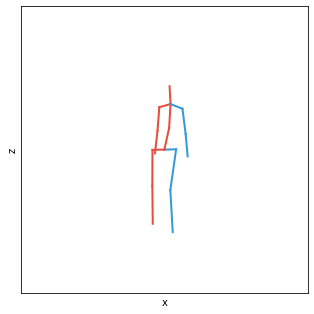

In [26]:
# Visualize random samples
import matplotlib.gridspec as gridspec

# 1080p	= 1,920 x 1,080
fig = plt.figure( figsize=(19.2, 10.8) )

gs1 = gridspec.GridSpec(2, 2) # 5 rows, 9 columns
gs1.update(wspace=-0.00, hspace=0.05) # set the spacing between axes.
plt.axis('off')

subplot_idx, exidx = 1, 1

ax1 = plt.subplot(gs1[subplot_idx-1])
viz.show2Dpose( train_set_2d_raw[(1, 'Purchases', 'Purchases.54138969.h5')][180], ax1,add_labels=True )
ax1.invert_yaxis()


Next:

1. Make sure alpha_pose skeleton same with human

In [27]:
# Load Human3.6M Skeleton

import torch.nn as nn
import torch.optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch



import pickle

index_alphapose={
    # Use 17 skeleton point
    "Nose": 0,
    #"Neck": "-",
    "RShoulder": 6,
    "RElbow": 8,
    "RWrist": 10,
    "LShoulder": 5,
    "LElbow": 7,
    "LWrist": 9,
    "RHip": 12,
    "RKnee": 14,
    "RAnkle": 16,
    "LHip": 11,
    "LKnee": 13,
    "LAnkle": 15,
    "REye": 2,
    "LEye": 1,
    "REar": 4,
    "LEar": 3
}

train_2d_human = '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/train_2d.pth.tar'
test_2d_human = '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/data/test_2d.pth.tar'

train_2d_alpha= "../../3d_pose_baseline_pytorch/Human3.6M_AlphaPose_Train_Unnormalized.pkl"
test_2d_alpha= "../../3d_pose_baseline_pytorch/Human3.6M_AlphaPose_Test_Unnormalized.pkl"

def data_converter(data):
    data=data['keypoints']
    keypoints=[]
    kp_score=[]
    for a in range (0,len(data)):
        score=[]
        if ((a+3)%3==0):
            keypoints.append(data[a])
            keypoints.append(data[a+1])
        elif((a+1)%3==0):
            score=[data[a]]
            kp_score.append(score)

    return keypoints
    
    
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0


# Function to find next in alpha pose because alpha pose did not have neck

def find_neck(alpha_example):
    
    # 10 and 11 is x and y coordinate for left shoulder of alpha pose
    x1= alpha_example[:,10] 
    y1= alpha_example[:,11]
    
    
    # 12 and 13 is x and y coordinate for right shoulder of alpha pose
    x2= alpha_example[:,12]
    y2= alpha_example[:,13]
    
    # Result will be  neck coordinate(array([586.35131836, 472.55082703]), array([559.9307251 , 480.63751221])) ((x1,x2),(y1,y2))
    neck_= ((x1 + x2)/2, (y1 + y2)/2)
    
    result_neck=[]
    for a,b in zip(neck_[0],neck_[1]):
        result_neck.append([a,b])
    
    neck=np.asarray(result_neck)
    return neck

def norm_alpha(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,index_alphapose['Nose']*2:index_alphapose['Nose']*2+2]
    Neck = find_neck(X)
    RShoulder = X[:,index_alphapose['RShoulder']*2:index_alphapose['RShoulder']*2+2]
    RElbow = X[:,index_alphapose['RElbow']*2:index_alphapose['RElbow']*2+2]
    RWrist = X[:,index_alphapose['RWrist']*2:index_alphapose['RWrist']*2+2]
    LShoulder = X[:,index_alphapose['LShoulder']*2:index_alphapose['LShoulder']*2+2]
    LElbow = X[:,index_alphapose['LElbow']*2:index_alphapose['LElbow']*2+2]
    LWrist = X[:,index_alphapose['LWrist']*2:index_alphapose['LWrist']*2+2]
    RHip = X[:,index_alphapose['RHip']*2:index_alphapose['RHip']*2+2]
    RKnee = X[:,index_alphapose['RKnee']*2:index_alphapose['RKnee']*2+2]
    RAnkle = X[:,index_alphapose['RAnkle']*2:index_alphapose['RAnkle']*2+2]
    LHip = X[:,index_alphapose['LHip']*2:index_alphapose['LHip']*2+2]
    LKnee = X[:,index_alphapose['LKnee']*2:index_alphapose['LKnee']*2+2]
    LAnkle = X[:,index_alphapose['LAnkle']*2:index_alphapose['LAnkle']*2+2]
    REye = X[:,index_alphapose['REye']*2:index_alphapose['REye']*2+2]
    LEye = X[:,index_alphapose['LEye']*2:index_alphapose['LEye']*2+2]
    REar = X[:,index_alphapose['REar']*2:index_alphapose['REar']*2+2]
    LEar = X[:,index_alphapose['LEar']*2:index_alphapose['LEar']*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
  

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
 

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts

    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts


    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

def find_neck_plot(alpha_example):
    
    # 10 and 11 is x and y coordinate for left shoulder of alpha pose
    x1= alpha_example[:,10] 
    y1= alpha_example[:,11]
    
    
    # 12 and 13 is x and y coordinate for right shoulder of alpha pose
    x2= alpha_example[:,12]
    y2= alpha_example[:,13]

    neck_= [float((x1 + x2)/2), float((y1 + y2)/2)]
    neck_=np.asarray(neck_)

    return neck_

def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton_alpha(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 34)
    Nose = skeleton[:,index_alphapose['Nose']*2:index_alphapose['Nose']*2+2][0]

    Neck = find_neck_plot(skeleton)

    RShoulder = skeleton[:,index_alphapose['RShoulder']*2:index_alphapose['RShoulder']*2+2][0]
    RElbow = skeleton[:,index_alphapose['RElbow']*2:index_alphapose['RElbow']*2+2][0]
    RWrist = skeleton[:,index_alphapose['RWrist']*2:index_alphapose['RWrist']*2+2][0]
    LShoulder = skeleton[:,index_alphapose['LShoulder']*2:index_alphapose['LShoulder']*2+2][0]
    LElbow = skeleton[:,index_alphapose['LElbow']*2:index_alphapose['LElbow']*2+2][0]
    LWrist = skeleton[:,index_alphapose['LWrist']*2:index_alphapose['LWrist']*2+2][0]
    RHip = skeleton[:,index_alphapose['RHip']*2:index_alphapose['RHip']*2+2][0]
    RKnee = skeleton[:,index_alphapose['RKnee']*2:index_alphapose['RKnee']*2+2][0]
    RAnkle = skeleton[:,index_alphapose['RAnkle']*2:index_alphapose['RAnkle']*2+2][0]
    LHip = skeleton[:,index_alphapose['LHip']*2:index_alphapose['LHip']*2+2][0]
    LKnee = skeleton[:,index_alphapose['LKnee']*2:index_alphapose['LKnee']*2+2][0]
    LAnkle = skeleton[:,index_alphapose['LAnkle']*2:index_alphapose['LAnkle']*2+2][0]
    REye = skeleton[:,index_alphapose['REye']*2:index_alphapose['REye']*2+2][0]
    LEye = skeleton[:,index_alphapose['LEye']*2:index_alphapose['LEye']*2+2][0]
    REar = skeleton[:,index_alphapose['REar']*2:index_alphapose['REar']*2+2][0]
    LEar = skeleton[:,index_alphapose['LEar']*2:index_alphapose['LEar']*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot_alpha(sample):
    # sample is one-dimension array
    # e.g: (34,)
    if sample.shape[0] == 34:
        sample_norm = norm_alpha(sample.reshape(1,34))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_alpha(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_alpha(X_nor, 'ro')
        
        
        plt.tight_layout()
    else:
        print("sample is one-dimension array: (36,)")


def show_video_frames(myFrameNumber,videopath):
    cap = cv2.VideoCapture(videopath)
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    print("Total Frames: ", totalFrames)
    # check for valid frame number
    if myFrameNumber >= 0 & myFrameNumber <= totalFrames:
        # set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES,myFrameNumber-1)

    while True:
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
        plt.imshow(frame)
        plt.show() 
        break


        
def adjust_frame(human_path,alpha_path):
    train_2d = torch.load(human_path)
    # open a file, where you stored the pickled data
    file = open(alpha_path, 'rb')

    # dump information to that file
    data = pickle.load(file)

    # close the file
    file.close()
    count=0

    train_human36=train_2d.copy()
    train_alpha=data.copy()

    if(len(train_2d.keys())==len(data.keys())):
        for key in data.keys():
            begin_frame=data[key].shape[0]-train_2d[key].shape[0]
            print("Frame to cut:", data[key].shape[0]-train_2d[key].shape[0])
            if (begin_frame<0):
                count=count+1
                del train_human36[key]
                del train_alpha[key]
            else:
                #Remove Beginning of Frames
                train_alpha[key]=train_alpha[key][begin_frame:, :]
                
                #Remove End of Frames
#                 train_alpha[key]=train_alpha[key][:-begin_frame, :]
    print(count)

    for key in train_alpha.keys():
        print(train_human36[key].shape[0]==train_alpha[key].shape[0])
    
    return train_alpha,train_human36


In [28]:
train_alpha,train_human36 = adjust_frame(train_2d_human,train_2d_alpha)

Frame to cut: 1
Frame to cut: 4
Frame to cut: 4
Frame to cut: 1
Frame to cut: 5
Frame to cut: 3
Frame to cut: 3
Frame to cut: 1
Frame to cut: 6
Frame to cut: 4
Frame to cut: 4
Frame to cut: 1
Frame to cut: 2
Frame to cut: 5
Frame to cut: 5
Frame to cut: 1
Frame to cut: 2
Frame to cut: 5
Frame to cut: 2
Frame to cut: 2
Frame to cut: 2
Frame to cut: 5
Frame to cut: 3
Frame to cut: 1
Frame to cut: 1
Frame to cut: 3
Frame to cut: 3
Frame to cut: 1
Frame to cut: 1
Frame to cut: 5
Frame to cut: 5
Frame to cut: 1
Frame to cut: 3
Frame to cut: 4
Frame to cut: 8
Frame to cut: 1
Frame to cut: 1
Frame to cut: 4
Frame to cut: 4
Frame to cut: 1
Frame to cut: 1
Frame to cut: 2
Frame to cut: 3
Frame to cut: 2
Frame to cut: 2
Frame to cut: 4
Frame to cut: 4
Frame to cut: 2
Frame to cut: 2
Frame to cut: 3
Frame to cut: 3
Frame to cut: 1
Frame to cut: 17
Frame to cut: 4
Frame to cut: 4
Frame to cut: 2
Frame to cut: 2
Frame to cut: 4
Frame to cut: 4
Frame to cut: 2
Frame to cut: 4
Frame to cut: 4
Frame t

In [29]:
train_alpha.keys()

dict_keys([(1, 'Directions', 'Directions 1.54138969.h5'), (1, 'Directions', 'Directions 1.55011271.h5'), (1, 'Directions', 'Directions 1.58860488.h5'), (1, 'Directions', 'Directions 1.60457274.h5'), (1, 'Directions', 'Directions.54138969.h5'), (1, 'Directions', 'Directions.55011271.h5'), (1, 'Directions', 'Directions.58860488.h5'), (1, 'Directions', 'Directions.60457274.h5'), (1, 'Discussion', 'Discussion 1.54138969.h5'), (1, 'Discussion', 'Discussion 1.55011271.h5'), (1, 'Discussion', 'Discussion 1.58860488.h5'), (1, 'Discussion', 'Discussion 1.60457274.h5'), (1, 'Discussion', 'Discussion.54138969.h5'), (1, 'Discussion', 'Discussion.55011271.h5'), (1, 'Discussion', 'Discussion.58860488.h5'), (1, 'Discussion', 'Discussion.60457274.h5'), (1, 'Eating', 'Eating 2.54138969.h5'), (1, 'Eating', 'Eating 2.55011271.h5'), (1, 'Eating', 'Eating 2.58860488.h5'), (1, 'Eating', 'Eating 2.60457274.h5'), (1, 'Eating', 'Eating.54138969.h5'), (1, 'Eating', 'Eating.55011271.h5'), (1, 'Eating', 'Eating.5

Next:
1. Reverse engineering for plotting unnormalized human 3.6M 2D
2. Learn the mapping from open pose to 2D data
3. Learn the mapping from alpha pose to 2D Data
4. Arrange the index from alpha pose
5. Learn the neural network again
6. Get Alpha Pose unnormalized

## Mapping Alpha Pose to Human3.6M

### Mapping Helper Function

In [30]:

index_alphapose={
    # Use 17 skeleton point
    "Nose": 0,
    "RShoulder": 6,
    "RElbow": 8,
    "RWrist": 10,
    "LShoulder": 5,
    "LElbow": 7,
    "LWrist": 9,
    "RHip": 12,
    "RKnee": 14,
    "RAnkle": 16,
    "LHip": 11,
    "LKnee": 13,
    "LAnkle": 15,
    "REye": 2,
    "LEye": 1,
    "REar": 4,
    "LEar": 3,
    
    #Feature added
    "Neck": 17,
    "Thorax":18,
    "Spine" :19,
    "Hip": 20,
}


index_mapping={
# Alpha Pose to Human 3.6M
"Hip": [20, 0],
"RHip": [12,1],
"RKnee": [14,2],
"RFoot": [16,3],
"LHip": [11,6],
"LKnee": [13,7],
"LFoot": [15,8],
"Spine": [19,12],
"Thorax": [18,13],
"Head": [17,15],
"LShoulder": [5,17],
"LElbow": [7,18],
"LWrist": [9,19],
"RShoulder": [6,25],
"RElbow": [8,26],
"RWrist": [10,27]
}



def count_head(alpha_pose):
    x = (alpha_pose[index_alphapose['LEar']*2]+alpha_pose[index_alphapose['REar']*2])/2
    y = (alpha_pose[index_alphapose['LEar']*2+1]+alpha_pose[index_alphapose['REar']*2+1])/2
    return x,y


def count_thorax(alpha_pose):
    x = (alpha_pose[index_alphapose['LShoulder']*2]+alpha_pose[index_alphapose['RShoulder']*2])/2
    y = (alpha_pose[index_alphapose['LShoulder']*2+1]+alpha_pose[index_alphapose['RShoulder']*2+1])/2
    return x,y


def count_spine(alpha_pose):
    hip_x,hip_y=count_hip(alpha_pose)
    thorax_x,thorax_y=count_thorax(alpha_pose)
    x = (hip_x+thorax_x)/2
    y = (hip_y+thorax_y)/2
    return x,y

def count_hip(alpha_pose):
    x = (alpha_pose[index_alphapose['LHip']*2]+alpha_pose[index_alphapose['RHip']*2])/2
    y = (alpha_pose[index_alphapose['LHip']*2+1]+alpha_pose[index_alphapose['RHip']*2+1])/2
    return x,y

def add_features(alpha_pose):
    #Count Head
    head_x,head_y=count_head(alpha_pose)
    alpha_pose=np.append(alpha_pose,(head_x,head_y))
    
    #Count Thorax
    thorax_x,thorax_y=count_thorax(alpha_pose)
    alpha_pose=np.append(alpha_pose,(thorax_x,thorax_y))
 
    
    #Count Spine
    spine_x,spine_y=count_spine(alpha_pose)
    alpha_pose=np.append(alpha_pose,(spine_x,spine_y))
    
    #Count Hip
    hip_x,hip_y=count_hip(alpha_pose)
    alpha_pose=np.append(alpha_pose,(hip_x,hip_y))
    
    return alpha_pose
    



### Mapping Main Function

In [31]:
def map_alpha_to_human(alpha_pose):
    alpha_pose=add_features(alpha_pose)
    temp_list = [None] * 64
    for a,b in index_mapping.items():
        temp_list[b[1]*2]=alpha_pose[b[0]*2]
        temp_list[b[1]*2+1]=alpha_pose[b[0]*2+1]
    human36m=np.asarray(temp_list)
    return human36m
    
    

### Function to Visualize Mapping Result and Original and 3D

In [32]:
# Visualize random samples190
import matplotlib.gridspec as gridspec

def visualize_2D(human36m):
    # 1080p	= 1,920 x 1,080
    fig = plt.figure( figsize=(19.2, 10.8) )

    gs1 = gridspec.GridSpec(2, 2) # 5 rows, 9 columns
    gs1.update(wspace=-0.00, hspace=0.05) # set the spacing between axes.
    plt.axis('off')

    subplot_idx, exidx = 1, 1

    ax1 = plt.subplot(gs1[subplot_idx-1])
    viz.show2Dpose( human36m, ax1,add_labels=True )
    ax1.invert_yaxis()
    
def visualize_3D(path):

    # 1080p	= 1,920 x 1,080
    fig = plt.figure( figsize=(19.2, 10.8) )

    gs1 = gridspec.GridSpec(2, 2) # 5 rows, 9 columns
    gs1.update(wspace=-0.00, hspace=0.05) # set the spacing between axes.
    plt.axis('off')

    subplot_idx, exidx = 1, 1

    # Plot 3d gt
    ax2 = plt.subplot(gs1[subplot_idx], projection='3d')
    p3d = path
    show3Dpose( p3d, ax2 )


# Do 3D Prediction from Custom Video

In [33]:

# Opening JSON file 
f = open('../AlphaPose_Standing_01.json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  

# Closing file 
f.close() 

Total Frames:  5342.0


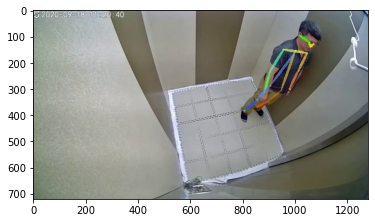

In [34]:
video_json="../../../AlphaPose/examples/res/AlphaPose_Standing_01.avi"
show_video_frames(4400,video_json)

In [35]:
alpha_example=np.asarray(data_converter(data[4400]))


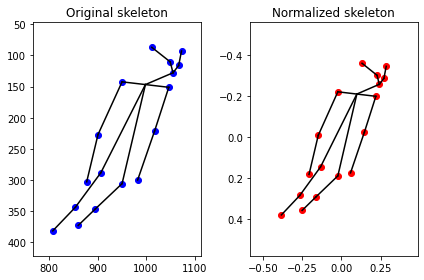

In [36]:
plot_alpha(alpha_example)


In [37]:
human36m_alpha_example=map_alpha_to_human(alpha_example)


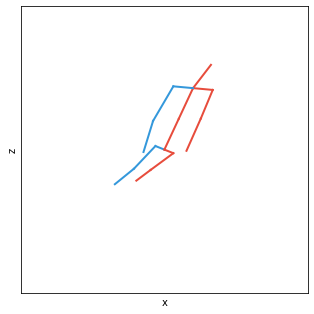

In [38]:
visualize_2D(human36m_alpha_example)

### Normalize Human36m from AlphaPose before inference

In [39]:
def normalize_single_data(data, data_mean, data_std, dim_to_use ):
    """Normalizes a dictionary of poses

    Args
    data: dictionary where values are
    data_mean: np vector with the mean of the data
    data_std: np vector with the standard deviation of the data
    dim_to_use: list of dimensions to keep in the data
    Returns
    data_out: dictionary with same keys as data, but values have been normalized
    """

    data= data[dim_to_use]
    mu = data_mean[dim_to_use]
    stddev = data_std[dim_to_use]
    data_out= np.divide( (data - mu), stddev )

    return data_out

In [40]:
human36m_alpha_example_normalized=normalize_single_data(human36m_alpha_example,data_mean_2d,data_std_2d,dim_to_use_2d)



In [41]:
human36m_alpha_example_normalized=human36m_alpha_example_normalized.astype('float')

# Inference Test

## Create Data Loader

In [42]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-




class Human36M_testing(Dataset):
    def __init__(self, skeleton):
        """
        :param actions: list of actions to use
        :param data_path: path to dataset
        :param use_hg: use stacked hourglass detections
        :param is_train: load train/test dataset
        """

        self.test_inp, self.test_out = [], []

        # loading data
        # load test data
       
        self.test_inp.append(skeleton)


    def __getitem__(self, index):
        inputs = torch.from_numpy(self.test_inp[index]).float()

        return inputs

    def __len__(self):
        return len(self.test_inp)


In [69]:

test_loader = DataLoader(
    dataset=Human36M_testing(skeleton=human36m_alpha_example_normalized),
    batch_size=1024,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

In [70]:
test_loader.dataset.test_inp[0]

array([ 3.68200659, -1.93671666,  3.15167741, -2.02711276,  2.71715714,
       -2.96456952,  2.30736874, -3.44621611,  4.10324632, -1.83632863,
        3.41910753, -3.05886343,  3.04681027, -3.77531259,  3.95005685,
       -2.16514528,  4.17880681, -2.28576589,  4.48403884, -2.40840344,
        4.85109046, -2.44265564,  4.52304946, -2.09796949,  4.16076733,
       -1.10165961,  3.43013865, -2.52784843,  2.74327302, -1.89964686,
        2.61744294, -0.86513897])

In [71]:


model_path='/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/checkpoint/test/ckpt_best.pth.tar'
# create model
print(">>> creating model")
model = LinearModel()
model = model.cuda()
model.apply(weight_init)
print(">>> total params: {:.2f}M".format(sum(p.numel() for p in model.parameters()) / 1000000.0))
criterion = nn.MSELoss(size_average=True).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

print(">>> loading ckpt from '{}'".format('/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/checkpoint/test/ckpt_best.pth.tar'))
ckpt = torch.load(model_path)
start_epoch = ckpt['epoch']
err_best = ckpt['err']
glob_step = ckpt['step']
lr_now = ckpt['lr']
model.load_state_dict(ckpt['state_dict'])
optimizer.load_state_dict(ckpt['optimizer'])
print(">>> ckpt loaded (epoch: {} | err: {})".format(start_epoch, err_best))
    
def test(test_loader, model, criterion, stat_3d, procrustes=False):
    losses = utils.AverageMeter()
    model.eval()

    all_dist = []
    pred_result=[]
    start = time.time()
    batch_time = 0
    bar = Bar('>>>', fill='>', max=len(test_loader))

    for i, inps in enumerate(test_loader):
        inputs = Variable(inps.cuda())
        
        with torch.no_grad():
            outputs = model(inputs)

        # calculate erruracy
        print(outputs.shape)
        outputs_unnorm = data_process.unNormalizeData(outputs.data.cpu().numpy(), stat_3d['mean'], stat_3d['std'], stat_3d['dim_use'])

        # remove dim ignored
        dim_use = np.hstack((np.arange(3), stat_3d['dim_use']))

        outputs_use = outputs_unnorm[:, dim_use]
        pred_result.append(outputs_unnorm)
        
        # update summary
        if (i + 1) % 100 == 0:
            batch_time = time.time() - start
            start = time.time()

        bar.suffix = '({batch}/{size}) | batch: {batchtime:.4}ms | Total: {ttl} | ETA: {eta:} | loss: {loss:.6f}' \
            .format(batch=i + 1,
                    size=len(test_loader),
                    batchtime=batch_time * 10.0,
                    ttl=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg)
        bar.next()
    bar.finish()
    return pred_result

>>> creating model
>>> total params: 4.29M
>>> loading ckpt from '/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/checkpoint/test/ckpt_best.pth.tar'
>>> ckpt loaded (epoch: 147 | err: 42.151899649376176)


/media/ivan/Ivan/Project Lab/THESIS_FALL_DETECTION/2D to 3D Pose/3d_pose_baseline_pytorch/src/model.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight)
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [72]:
pred_result=test(test_loader, model, criterion, new_stat_3d)

torch.Size([1, 48])


In [73]:
pred_result[0].shape

(1, 96)

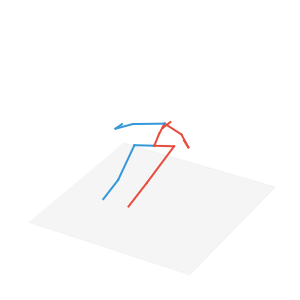

In [74]:
visualize_3D(pred_result[0])

## Visualizing Prediction Result

In [75]:
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D


def show3Dpose_anim(): # blue, orange
    """
    Visualize a 3d skeleton

    Args
    channels: 96x1 vector. The pose to plot.
    ax: matplotlib 3d axis to draw on
    lcolor: color for left part of the body
    rcolor: color for right part of the body
    add_labels: whether to add coordinate labels
    Returns
    Nothing. Draws on ax.
    """
    lcolor="#3498db"
    rcolor="#e74c3c"
    add_labels=False
    # Create a figure and a 3D Axes


    assert channels.size == len(data_utils.H36M_NAMES)*3, "channels should have 96 entries, it has %d instead" % channels.size
    vals = np.reshape( channels, (len(data_utils.H36M_NAMES), -1) )

    I   = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1 # start points
    J   = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1 # end points
    LR  = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)

    # Make connection matrix
    for i in np.arange( len(I) ):
        x, y, z = [np.array( [vals[I[i], j], vals[J[i], j]] ) for j in range(3)]
        ax.plot(x, y, z, lw=3, c=lcolor if LR[i] else rcolor)

    RADIUS = 750 # space around the subject
    xroot, yroot, zroot = vals[0,0], vals[0,1], vals[0,2]
    ax.set_xlim3d([-RADIUS+xroot, RADIUS+xroot])
    ax.set_zlim3d([-RADIUS+zroot, RADIUS+zroot])
    ax.set_ylim3d([-RADIUS+yroot, RADIUS+yroot])

    if add_labels:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

    # Get rid of the ticks and tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.set_zticklabels([])

    # Get rid of the panes (actually, make them white)
    white = (1.0, 1.0, 1.0, 0.0)
    ax.w_xaxis.set_pane_color(white)
    ax.w_yaxis.set_pane_color(white)
    # Keep z pane

    # Get rid of the lines in 3d
    ax.w_xaxis.line.set_color(white)
    ax.w_yaxis.line.set_color(white)
    ax.w_zaxis.line.set_color(white)
    ax.view_init(elev=0, azim=-70)

    return fig,

def animate(i):
    # azimuth angle : 0 deg to 360 deg
#     ax.view_init(elev=0, azim=i*4)
    # elevation angle : -180 deg to 180 deg
    ax.view_init(elev=(i-45)*4, azim=-70)
    return fig,
    


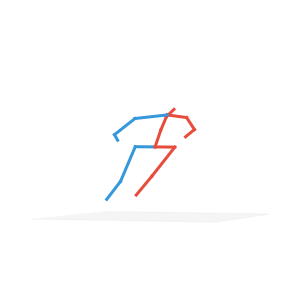

In [76]:

fig = plt.figure()
ax = Axes3D(fig)

channels = pred_result[0]
ani = animation.FuncAnimation(fig, animate, init_func=show3Dpose_anim,
                               frames=180,interval=20, blit=True)

In [77]:
fn = 'rotate_elev'
ani.save(fn+'.mp4',writer='ffmpeg',fps=1000/50)
ani.save(fn+'.gif',writer='imagemagick',fps=1000/50)

MovieWriter imagemagick unavailable; using Pillow instead.


# Do Mapping and Visualize DATASET

In [52]:
train_alpha.keys()

dict_keys([(1, 'Directions', 'Directions 1.54138969.h5'), (1, 'Directions', 'Directions 1.55011271.h5'), (1, 'Directions', 'Directions 1.58860488.h5'), (1, 'Directions', 'Directions 1.60457274.h5'), (1, 'Directions', 'Directions.54138969.h5'), (1, 'Directions', 'Directions.55011271.h5'), (1, 'Directions', 'Directions.58860488.h5'), (1, 'Directions', 'Directions.60457274.h5'), (1, 'Discussion', 'Discussion 1.54138969.h5'), (1, 'Discussion', 'Discussion 1.55011271.h5'), (1, 'Discussion', 'Discussion 1.58860488.h5'), (1, 'Discussion', 'Discussion 1.60457274.h5'), (1, 'Discussion', 'Discussion.54138969.h5'), (1, 'Discussion', 'Discussion.55011271.h5'), (1, 'Discussion', 'Discussion.58860488.h5'), (1, 'Discussion', 'Discussion.60457274.h5'), (1, 'Eating', 'Eating 2.54138969.h5'), (1, 'Eating', 'Eating 2.55011271.h5'), (1, 'Eating', 'Eating 2.58860488.h5'), (1, 'Eating', 'Eating 2.60457274.h5'), (1, 'Eating', 'Eating.54138969.h5'), (1, 'Eating', 'Eating.55011271.h5'), (1, 'Eating', 'Eating.5

#### Set Visualization Path

In [53]:
# SET VISUALIZATION PATH

visualize_key=(1, 'Waiting', 'Waiting 1.54138969.h5')
path_endpoint=os.path.splitext(visualize_key[2])[0]
path_3D=os.path.splitext(path_endpoint)[0]

visualize_key3d=(visualize_key[0], visualize_key[1], path_3D+".cdf")
frame_number=0
video_path="../../Dataset/Human3.6m/Videos/S"+str(visualize_key[0])+"/Videos/"+str(path_endpoint)+".mp4"



#### Visualize frame of videos

Total Frames:  1441.0


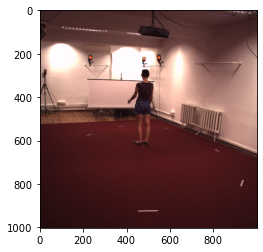

In [54]:
show_video_frames(frame_number,video_path)

#### Visualize Alpha Pose 

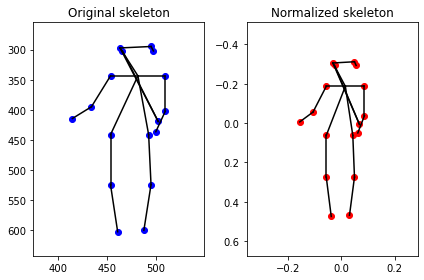

In [55]:
plot_alpha(train_alpha[visualize_key][frame_number])

#### Visualize Human3.6M from Alpha Pose

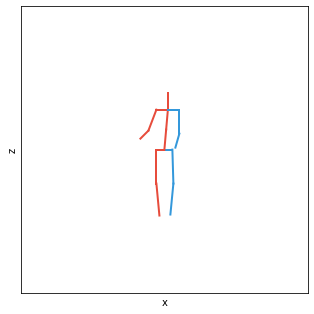

In [56]:
alpha_pose=train_alpha[(visualize_key)][frame_number]
human36m_alpha=map_alpha_to_human(alpha_pose)
visualize_2D(human36m_alpha)

#### Visualize original human 3.6M

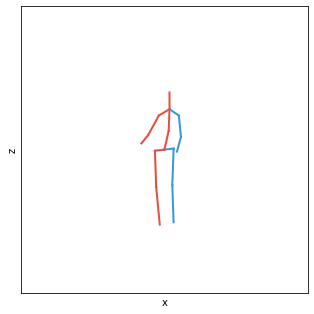

In [57]:
visualize_2D(train_set_2d_raw[(visualize_key)][frame_number])

#### Visualize GT 3D Result of Human 3.6M

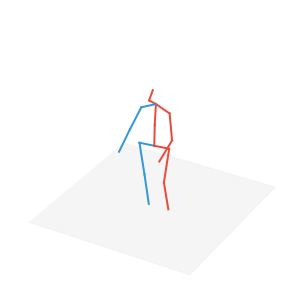

In [58]:
reshaped=train_set_3d[visualize_key3d][frame_number].reshape(1,48)
unnorm = data_process.unNormalizeData(reshaped, new_stat_3d['mean'], new_stat_3d['std'], new_stat_3d['dim_use'])
visualize_3D(unnorm)

#### Visualize 3D Prediction of Human 3.6M

In [59]:
human36m_=normalize_single_data(train_set_2d_raw[(visualize_key)][frame_number],data_mean_2d,data_std_2d,dim_to_use_2d)

In [60]:
human36m_=human36m_.astype('float')

In [61]:
human36m_ = DataLoader(
    dataset=Human36M_testing(skeleton=human36m_),
    batch_size=1024,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

In [62]:
human36m_=test(human36m_, model, criterion, new_stat_3d)

torch.Size([1, 48])


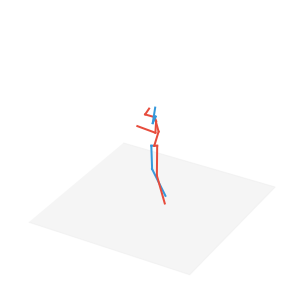

In [63]:
visualize_3D(human36m_[0])

#### Visualize 3D Prediction of Alpha Pose Mapping

In [64]:
alphapose_=normalize_single_data(human36m_alpha,data_mean_2d,data_std_2d,dim_to_use_2d)

In [65]:
alphapose_=alphapose_.astype('float')

In [66]:
alphapose_ = DataLoader(
    dataset=Human36M_testing(skeleton=alphapose_),
    batch_size=1024,
    shuffle=False,
    num_workers=8,
    pin_memory=True)

In [67]:
alphapose_=test(alphapose_, model, criterion, new_stat_3d)

torch.Size([1, 48])


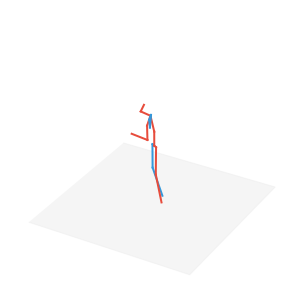

In [68]:
visualize_3D(alphapose_[0])